## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [3]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from model_scripts.train_model_dcec import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

/home/k64835/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/k64835/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Dataset prep: B10

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [17]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'b4t')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'b4t')
patch_tensor_train.shape, patch_tensor_eval.shape

3
0.02608695652173913
19
0.16521739130434782
33
0.28695652173913044
53
0.4608695652173913
78
0.6782608695652174
84
0.7304347826086957
93
0.808695652173913
3
0.02608695652173913
19
0.16521739130434782
33
0.28695652173913044
53
0.4608695652173913
78
0.6782608695652174
84
0.7304347826086957
93
0.808695652173913
3
0.02608695652173913
19
0.16521739130434782
33
0.28695652173913044
53
0.4608695652173913
78
0.6782608695652174
84
0.7304347826086957
93
0.808695652173913
3
0.02608695652173913
19
0.16521739130434782
33
0.28695652173913044
53
0.4608695652173913
78
0.6782608695652174
84
0.7304347826086957
93
0.808695652173913
3
0.02608695652173913
19
0.16521739130434782
33
0.28695652173913044
53
0.4608695652173913
78
0.6782608695652174
84
0.7304347826086957
93
0.808695652173913
19
0.16521739130434782
27
0.23478260869565218
33
0.28695652173913044
53
0.4608695652173913
78
0.6782608695652174
84
0.7304347826086957
93
0.808695652173913
19
0.16521739130434782
27
0.23478260869565218
33
0.28695652173913044


(torch.Size([2425, 7, 5, 64, 64]), torch.Size([48, 7, 5, 64, 64]))

In [37]:
np.unique(images_visualisation_train[764][6][-1])

array([0.        , 0.80869565])

In [5]:
np.unique(patch_tensor_train[:,:,-1])

array([0.0003, 0.0019, 0.0023, 0.0027, 0.0103, 0.0113, 0.0123, 0.0203,
       0.0207, 0.0211, 0.0217, 0.0223, 0.0227, 0.0301, 0.0311],
      dtype=float32)

In [6]:
train_tensor, test_tensor, train_field_numbers, test_field_numbers = train_test_split(
    patch_tensor_train, field_numbers_train, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_tensor, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_tensor, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(patch_tensor_eval, field_numbers_eval, batch_size=config.ae_batch_size, shuffle=False)

/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/dataset_creation.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 2, 1, 3, 4)   # (N, T, C, H, W) -> (N, C, T, H, W)


### Create Sub-Patches

In [7]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([620800, 7, 5, 4, 4]), torch.Size([12288, 7, 5, 4, 4]))

Get field numbers and co-ordinates as string

In [8]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167134.0_0_0'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [9]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

## Architecture 1: Conv3D Autoencoder with 1D Time Convolution

### Architecture

Input Data: ( N x C x D x H x W )

In [10]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- 1D Convolution (Time Aggregation) ---
        self.conv1d = nn.Conv1d(256 * patch_size * patch_size, 256 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=128 * patch_size * patch_size)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)  

        # --- 1D Deconvolution to Expand Time Back ---
        self.deconv1d = nn.ConvTranspose1d(256 * patch_size * patch_size, 256 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=128 * patch_size * patch_size)

        # --- 3D Deconvolutions ---
        self.unflatten = nn.Unflatten(1, (256, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Reshape for 1D Conv ---
        b, c, t, h, w = x.shape  
        # print("x shape initial: ",x.shape)
        x = x.view(b, c * h * w, t)                     # (batch, 800, time)

        # print(f"Shape before 1D Conv: {x.shape}") 
        x = self.conv1d(x)                              # Time aggregation
        # print(f"Shape after 1D Conv: {x.shape}")      # (batch, 800, 1)

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x) 

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x)) 

        # --- Expand Time Back ---
        # print(f"Shape before reshape: {x.shape}")  # (batch, 800, time_steps)
        x = x.view(b, 256 * self.patch_size * self.patch_size, 1)  
        x = self.deconv1d(x) 
        # print(f"Shape after Deconv1D: {x.shape}")  # (batch, 800, time_steps)

        # --- Reshape for 3D Deconvolutions ---
        x = x.view(b, -1, self.time_steps, h, w)  
        # print("x before unflatten", x.shape)

        # --- 3D Deconvolutions ---
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)  

        return z, x_reconstructed

### Training

In [11]:
device = 'cuda'
epochs = 20
lr = 0.01
momentum=0.9
latent_dim=32
channels = 5
time_steps = 7
optimizer = 'SGD'
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(5, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(4096, 4096, kernel_size=(7,), stride=(1,), groups=2048)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=4096, bias=True)
  (deconv1d): ConvTranspose1d(4096, 4096, kernel_size=(7,), stride=(1,), groups=2048)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deco

In [39]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

Epoch 1/20, Train Loss: 0.004338, Test Loss: 0.004407
Epoch 2/20, Train Loss: 0.004338, Test Loss: 0.004394
Epoch 3/20, Train Loss: 0.004338, Test Loss: 0.004401
Epoch 4/20, Train Loss: 0.004338, Test Loss: 0.004404
Epoch 5/20, Train Loss: 0.004338, Test Loss: 0.004399
Epoch 6/20, Train Loss: 0.004338, Test Loss: 0.004396
Epoch 7/20, Train Loss: 0.004337, Test Loss: 0.004395
Epoch 8/20, Train Loss: 0.004337, Test Loss: 0.004396
Epoch 9/20, Train Loss: 0.004337, Test Loss: 0.004394
Epoch 10/20, Train Loss: 0.004337, Test Loss: 0.004395
Epoch 11/20, Train Loss: 0.004337, Test Loss: 0.004404
Epoch 12/20, Train Loss: 0.004337, Test Loss: 0.004392
Epoch 13/20, Train Loss: 0.004337, Test Loss: 0.004395
Epoch 14/20, Train Loss: 0.004337, Test Loss: 0.004393
Epoch 15/20, Train Loss: 0.004337, Test Loss: 0.004394
Epoch 16/20, Train Loss: 0.004336, Test Loss: 0.004394
Epoch 17/20, Train Loss: 0.004337, Test Loss: 0.004393
Epoch 18/20, Train Loss: 0.004336, Test Loss: 0.004394
Epoch 19/20, Train 

### Evaluation

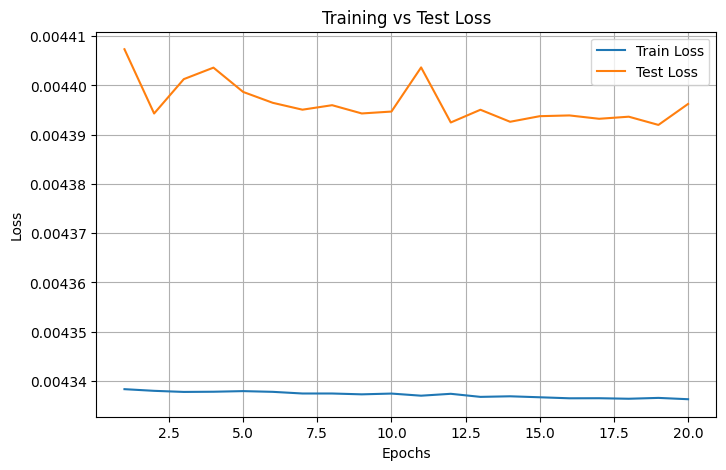

In [40]:
plot_loss(train_losses, test_losses)

Load Saved Model to skip Training

In [ ]:
# with open(config.kmeans_ae_b10_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [ ]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.ae_b10_path, 'rb') as file:
#     trained_model = pickle.load(file)

In [ ]:
# for batch_inputs, batch_field_numbers in dataloader_train:
#     print("Batch Inputs Shape:", batch_inputs.shape)  
#     # print("Batch Field Numbers:", batch_field_numbers)
#     # print("Dates:", timestamps.shape)
#     break 

Use trained Encoder part to get the features for train, test and evaluation Data

In [11]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [12]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=201)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [ ]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)
threshold

0.1

Clustering Accuracy

In [ ]:
acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Accuracy: 0.5245901639344263
Precision: [0.45454545 0.60714286]
Recall: [0.57692308 0.48571429]
F1-score: [0.50847458 0.53968254]
F2-score: 0.5059523809523809


New code:

In [ ]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_best_mapping_new(eval_coord_dl, eval_subpatch_predictions, config.labels_path, threshold)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Selected 0 = Diseased mapping
Accuracy: 0.5245901639344263
Precision: [0.45454545 0.60714286]
Recall: [0.57692308 0.48571429]
F1-score: [0.50847458 0.53968254]
F2-score: 0.5059523809523809


In [15]:
# from evaluation_scripts.patch_evaluation_helper import get_clustering_accuracy

# acc, precision, recall, f1, f2 = get_clustering_accuracy(field_numbers_eval, eval_subpatch_predictions, config.labels_path)
# print("Accuracy:",acc)
# print("Precision:",precision)
# print("Recall:",recall)
# print("F1-score:",f1)
# print("F2-score",f2)

In [69]:
train_field_labels = assign_field_labels_ae_train(combined_train_coords, train_subpatch_predictions, disease, threshold) #for box drawing

In [32]:
# with open(config.ae_b10_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [33]:
# with open(config.kmeans_ae_b10_path, 'wb') as file:
#     pickle.dump(kmeans, file)

/home/k64835/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


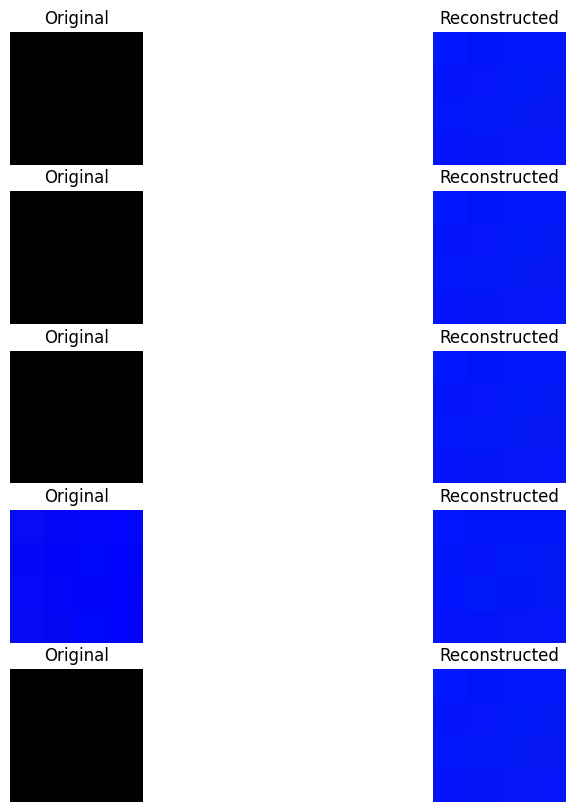

In [41]:
plot_reconstructed_images(trained_model, dataloader_train, 5, device)

## Architecture 2: Conv2D Autoencoder with Time as Channels

In [ ]:
class Conv2DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        
        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.view(b, c * t, h, w)      # Imp: Time steps as additional channels (B, C * D, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)

        # print(x.shape)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        
        # print(x.shape)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return z, x_reconstructed


### Training

In [ ]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
channels = 10
optimizer = 'Adam'
time_steps = 7
patch_size = config.subpatch_size

model = Conv2DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

In [ ]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=0.9, device=device)

### Evaluation

In [ ]:
plot_loss(train_losses, test_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [ ]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [ ]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=42)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Convert Subpatch labels to Field labels

In [ ]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Clustering Accuracy

In [ ]:
acc, precision_per_class, recall_per_class, f1_per_class, fmi = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)
print("F2-score:", fmi)

In [ ]:
# with open(config.ae_b10_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [ ]:
# with open(config.kmeans_ae_b10_path, 'wb') as file:
#     pickle.dump(kmeans, file)

## Architecture 5: Conv2D Autoencoder with Residual Connections

### Architecture

In [ ]:
# class Conv2DAutoencoderRes(nn.Module):
#     def __init__(self, in_channels, time_steps, latent_size, patch_size):
#         super(Conv2DAutoencoderRes, self).__init__()

#         self.time_steps = time_steps
#         self.in_channels = in_channels

#         # --- Encoder (2D Convolutions with Residual Connections) ---
#         self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)  
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(128)  
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(256)  

#         # Skip connections
#         self.skip_conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=1, stride=1, padding=0)
#         self.skip_conv2 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0)
#         self.skip_conv3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)

#         # --- Fully Connected Latent Space ---
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
#         self.fc2 = nn.Linear(512, latent_size)

#         # --- Decoder (Fully Connected) ---
#         self.fc3 = nn.Linear(latent_size, 512)
#         self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

#         # --- Decoder (2D Deconvolutions) ---
#         self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(128)  
#         self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
#         self.bn5 = nn.BatchNorm2d(64)  
#         self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

#         # Skip connections for decoder
#         self.skip_conv4 = nn.ConvTranspose2d(256, 128, kernel_size=1, stride=1, padding=0)
#         self.skip_conv5 = nn.ConvTranspose2d(128, 64, kernel_size=1, stride=1, padding=0)

#     def forward(self, x):
#         # --- Encoder ---
#         b, c, t, h, w = x.shape
#         x = x.view(b, c * t, h, w)          # Imp: Merge time steps into channels (B, C * D, H, W)

#         # Residual Block 1
#         skip_x = self.skip_conv1(x)  
#         x = F.relu(self.bn1(self.conv1(x)))  
#         x = x + skip_x  # Residual connection

#         # Residual Block 2
#         skip_x = self.skip_conv2(x)
#         x = F.relu(self.bn2(self.conv2(x)))  
#         x = x + skip_x  # Residual connection

#         # Residual Block 3
#         skip_x = self.skip_conv3(x)
#         x = F.relu(self.bn3(self.conv3(x)))  
#         x = x + skip_x  # Residual connection

#         # --- Flatten and Fully Connected ---
#         x = self.flatten(x)
#         x = F.relu(self.fc1(x))
#         z = self.fc2(x)

#         # --- Decoder ---
#         x = F.relu(self.fc3(z))
#         x = F.relu(self.fc4(x))

#         # --- 2D Deconvolutions ---
#         x = x.view(b, 256, h, w)

#         # Residual Block 4
#         skip_x = self.skip_conv4(x)  
#         x = F.relu(self.bn4(self.deconv1(x)))  
#         x = x + skip_x  # Residual connection

#         # Residual Block 5
#         skip_x = self.skip_conv5(x)  
#         x = F.relu(self.bn5(self.deconv2(x)))  
#         x = x + skip_x  # Residual connection

#         x = self.deconv3(x)

#         # --- Reshape to B x C x D x H x W ---
#         x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w)

#         return z, x_reconstructed


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, transpose=False):
        super(ResidualBlock, self).__init__()
        if transpose:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)

    def forward(self, x):
        skip_x = self.skip_conv(x)
        x = F.relu(self.bn(self.conv(x)))
        x = x + skip_x  # Residual connection
        return x


class Conv2DAutoencoderRes(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoderRes, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder ---
        self.res_block1 = ResidualBlock(in_channels * time_steps, 64)
        self.res_block2 = ResidualBlock(64, 128)
        self.res_block3 = ResidualBlock(128, 256)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- Decoder Residual Blocks with ConvTranspose2d (for upsampling) ---
        self.deconv_block1 = ResidualBlock(256, 128, transpose=True)
        self.deconv_block2 = ResidualBlock(128, 64, transpose=True)
        self.deconv_block3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Reshape input to (B, C * T, H, W)
        b, c, t, h, w = x.shape
        x = x.view(b, c * t, h, w)

        # --- Encoder ---
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        # --- Latent Space ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # Reshape for deconvolution
        x = x.view(b, 256, h, w)

        # Decoder with residual blocks (upsampling with ConvTranspose2d)
        x = self.deconv_block1(x)
        x = self.deconv_block2(x)
        x = self.deconv_block3(x)

        # Reshape output back to (B, C, T, H, W)
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w)

        return z, x_reconstructed


### Training

In [ ]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
channels = 10
time_steps = 7
momentum=0.9
optimizer='Adam'
patch_size = config.subpatch_size

model = Conv2DAutoencoderRes(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

In [ ]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

### Evaluation

In [ ]:
plot_loss(train_losses, test_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [ ]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [ ]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=33)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Convert Subpatch labels to Field labels

In [ ]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [ ]:
# accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
# print(f"Evaluation Accuracy: {accuracy}")
# print(report)

Clustering Accuracy

In [ ]:
acc, precision_per_class, recall_per_class, f1_per_class, fmi = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)
print("F2-score:", fmi)

In [ ]:
with open(config.ae_b10_path, 'wb') as file:
    pickle.dump(trained_model, file)

In [ ]:
with open(config.kmeans_ae_b10_path, 'wb') as file:
    pickle.dump(kmeans, file)

## Final Images: Visualising Diseased Subpatches

In [ ]:
eval_images_box = images_visualisation_eval

In [ ]:
(eval_images_box[0][0].shape)

In [ ]:
np.unique(eval_images_box[0][0][:,:,-2])

In [ ]:
visualise_all_bands(eval_images_box[-15][3])

-48 -26

In [ ]:
visualize_temporal_stack_rgb(eval_images_box[-26])

In [ ]:
np.unique(eval_images_box[-26][-1][:,:,-2])

In [ ]:
draw_diseased_patches(eval_images_box, x_y_coords, config.images_save_path, config.patch_size)